# Transformers kütüphanesi kullanılarak CLIPTextModel ve CLIPTokenizer modelleri oluşturulur. 

    1) Tokenizer modeli kullanılarak verilen metinler tokenize edilir. 
    2) TextModel modeli kullanılarak tokenize edilen metinlerin görsel gömme vektörleri elde edilir.

In [4]:
import os
import dotenv
################################################
# load environment variables
dotenv.load_dotenv()
# get diffusers path
diffusers_path = os.getenv("DIFFUSERS_PATH")
# get models path
models_path = os.getenv("MODELS_PATH")
################################################
import sys
sys.path.append(diffusers_path)
sys.path.append(models_path)
import diffusers
from diffusers import StableDiffusionPipeline

print("Diffusers loaded from: ", diffusers_path)
print("Diffusers version: ", diffusers.__version__)

Diffusers loaded from:  /home/cilem/playground/ai-playground/diffusers
Diffusers version:  0.24.0


In [5]:
import torch
import logging

from PIL import Image
from transformers import CLIPTextModel, CLIPTokenizer

logger = logging.getLogger(__name__)

In [6]:
# Negative prompts embed eklenmedi, prompt embed test edilince eklenecek.
def encode_prompt(tokenizer, text_encoder, prompt, device, negative_prompt=None):
   
    # Prompt tokenize
    tokens = tokenizer(prompt, 
                       padding=False,
                       truncation=False,
                       return_tensors="pt")
    
    print("Tokens:", tokens, "attention_mask hakkinda daha fazla bilgi icin: https://huggingface.co/transformers/glossary.html#attention-mask")
        
    tokens_ids = tokens.input_ids
    print("Tokens IDs:", tokens_ids)

    # to device
    tokens_ids = tokens_ids.to(device)
    text_encoder = text_encoder.eval().to(device)


    # Prompt embeds
    prompt_embeds = text_encoder(tokens_ids)
    prompt_embeds = prompt_embeds[0]
    print("Prompt Embeds:", prompt_embeds)

    return prompt_embeds

In [7]:
# Prompt Tokenize ve Embedding Test
prompt = "A photo of a cat"
device = "cuda" if torch.cuda.is_available() else "cpu"

text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# close the ClipTextModel logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.WARN)

embeds = encode_prompt(tokenizer, text_encoder, prompt, device)
print("Embeds:", embeds)

Tokens: {'input_ids': tensor([[49406,   320,  1125,   539,   320,  2368, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])} attention_mask hakkinda daha fazla bilgi icin: https://huggingface.co/transformers/glossary.html#attention-mask
Tokens IDs: tensor([[49406,   320,  1125,   539,   320,  2368, 49407]])
Prompt Embeds: tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.1565,  0.1318,  0.7895,  ..., -2.1024, -1.1519, -0.3311],
         ...,
         [ 0.5830, -0.1372,  2.1518,  ..., -1.0520, -0.1529,  0.0968],
         [-0.0781,  0.9827,  0.6915,  ..., -2.8869,  0.0210, -0.4127],
         [-1.2166, -0.5148,  0.4800,  ..., -0.1383,  0.8114,  0.5570]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
Embeds: tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 1.15

tokenizer/special_tokens_map.json: 100%|██████████| 472/472 [00:00<00:00, 94.5kB/s]

tokenizer/tokenizer_config.json: 100%|██████████| 806/806 [00:00<00:00, 74.7kB/s]

scheduler/scheduler_config.json: 100%|██████████| 308/308 [00:00<00:00, 301kB/s]






unet/config.json: 100%|██████████| 743/743 [00:00<00:00, 1.57MB/s]





vae/config.json: 100%|██████████| 547/547 [00:00<00:00, 1.05MB/s]
tokenizer/merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 1.44MB/s]



tokenizer/vocab.json: 100%|██████████| 1.06M/1.06M [00:00<00:00, 2.19MB/s]









































































diffusion_pytorch_model.safetensors: 100%|██████████| 335M/335M [00:05<00:00, 57.6MB/s]


















































model.safetensors: 100%|██████████| 492M/492M [00:11<00:00, 44.5MB/s]
diffusion_pytorch_model.safetensors: 100%|██████████| 3.44G/3.44G [00:42<00:00, 80.4MB/s]
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.86it/s]
You hav

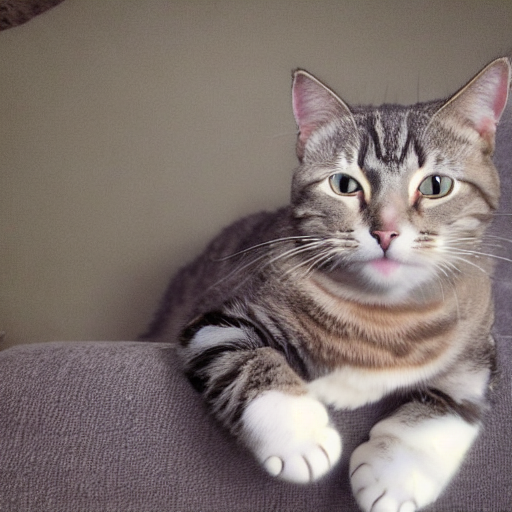

In [8]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", safety_checker=None)
pipe = pipe.to("cuda", torch.float16)

generator = torch.Generator(device="cuda").manual_seed(50)
generated = pipe(prompt_embeds=embeds,
                generator=generator,
                num_inference_steps = 20,
                height = 512,
                width = 512,            
                guidance_scale = 8).images[0]

generated.show()